# Sentiment Analysis

## Importing the libraries

In [4]:
import sys
!{sys.executable} -m pip install --quiet matplotlib seaborn nltk sklearn wordcloud

import re
import string
import warnings

import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from sklearn import metrics

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Importing the data set

In [5]:
data = pd.read_csv("sentiment.tsv", sep="\t")
data.columns = ["label", "body_text"]
data.head()

,label,body_text
0,pos,having a vodka tonic and looking forward to go...
1,pos,@ddlovatofans1neg1 Could you follow me please....
2,pos,@jordanknight for once.................. PLEAS...
3,neg,Had a dream about a walk in fast food resturau...
4,pos,@TroyBrownBBNews Yes... For a &quot;friend&quot;


In [6]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["label"] = label_encoder.fit_transform(data["label"])
data.head()

,label,body_text
0,1,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....
2,1,@jordanknight for once.................. PLEAS...
3,0,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;


## Cleaning the data

In [7]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, "", input_txt)
    return input_txt

### Remove Twitter handles

In [8]:
data["tidy_tweet"] = np.vectorize(remove_pattern)(data["body_text"], "@[\w]*")
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please.I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once.................. PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes... For a &quot;friend&quot;


### Remove special characters, numbers, punctuations

In [9]:
data["tidy_tweet"] = data["tidy_tweet"].str.replace("[^a-zA-Z#]", " ")
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,having a vodka tonic and looking forward to go...
1,1,@ddlovatofans1neg1 Could you follow me please....,Could you follow me please I would really app...
2,1,@jordanknight for once.................. PLEAS...,for once PLEASE TELL US WHY...
3,0,Had a dream about a walk in fast food resturau...,Had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,Yes For a quot friend quot


### Tokenise the tweets

In [10]:
tokenized_tweet = data["tidy_tweet"].apply(lambda x: x.split())
tokenized_tweet.head()

0    [having, a, vodka, tonic, and, looking, forwar...
1    [Could, you, follow, me, please, I, would, rea...
2    [for, once, PLEASE, TELL, US, WHY, u, were, th...
3    [Had, a, dream, about, a, walk, in, fast, food...
4                    [Yes, For, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

In [11]:
from nltk.stem.porter import *

stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) 
tokenized_tweet.head()

0    [have, a, vodka, tonic, and, look, forward, to...
1    [could, you, follow, me, pleas, I, would, real...
2    [for, onc, pleas, tell, US, whi, u, were, thin...
3    [had, a, dream, about, a, walk, in, fast, food...
4                     [ye, for, a, quot, friend, quot]
Name: tidy_tweet, dtype: object

### Joining the tokenised words

In [12]:
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = " ".join(tokenized_tweet[i])

data["tidy_tweet"] = tokenized_tweet
data.head()

,label,body_text,tidy_tweet
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot


### Adding a column for the tweet length and punctuation

In [13]:
def count_punct(txt):
    count = sum([1 for char in txt if char in string.punctuation])
    return round(count/(len(txt) - txt.count(" ")), 3) * 100

data["body_len"] = data["body_text"].apply(lambda x: len(x) - x.count(" "))
data["punct%"] = data["body_text"].apply(lambda x: count_punct(x))
data.head()

,label,body_text,tidy_tweet,body_len,punct%
0,1,having a vodka tonic and looking forward to go...,have a vodka tonic and look forward to go to s...,92,1.1
1,1,@ddlovatofans1neg1 Could you follow me please....,could you follow me pleas I would realli appre...,66,4.5
2,1,@jordanknight for once.................. PLEAS...,for onc pleas tell US whi u were think of thi ...,81,27.2
3,0,Had a dream about a walk in fast food resturau...,had a dream about a walk in fast food resturau...,96,1.0
4,1,@TroyBrownBBNews Yes... For a &quot;friend&quot;,ye for a quot friend quot,44,18.2


## Generating a word cloud

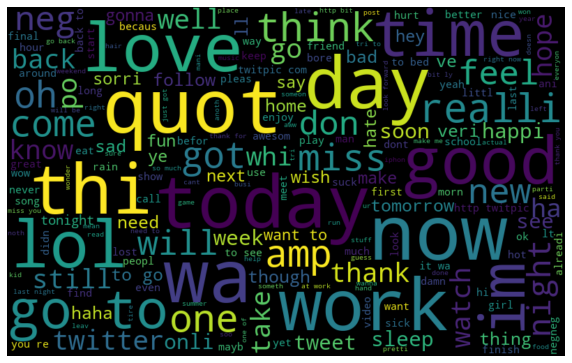

In [14]:
from wordcloud import WordCloud

all_words = " ".join([text for text in data["tidy_tweet"]])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Word cloud for negative tweets

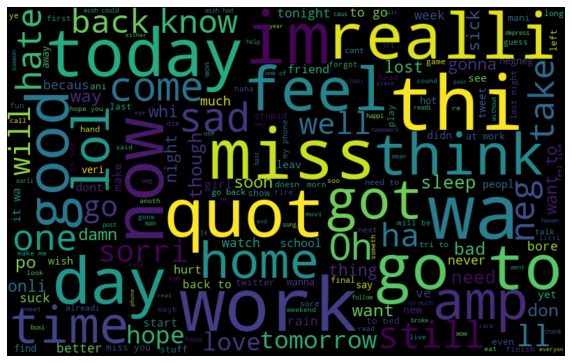

In [15]:
negative_words = " ".join([text for text in data["tidy_tweet"][data["label"] == 0]])
wordcloud = WordCloud(width=800, height = 500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

In [16]:
def extract_hashtag(words):
    hashtags = []
    for word in words:
        hashtag = re.findall(r"#(\w+)", word)
        hashtags.append(hashtag)
    return hashtags

HT_regular = extract_hashtag(data["tidy_tweet"][data["label"] == 0])
HT_negative = extract_hashtag(data["tidy_tweet"][data["label"] == 1])

HT_regular = sum(HT_regular, [])
HT_negative = sum(HT_negative, [])

a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({
    "Hashtag": list(a.keys()),
    "count": list(a.values())
})
d.head()

,Hashtag,count
0,github,1
1,fb,2
2,stupidgalaev,1
3,nswdet,1
4,bgt,1


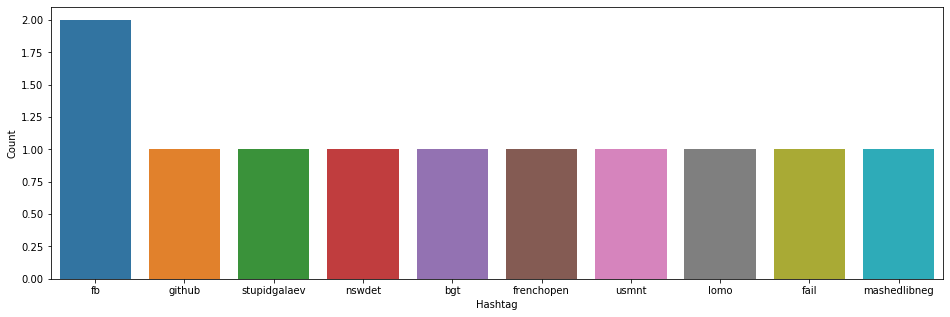

In [17]:
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({
    "Hashtag": list(a.keys()),
    "count": list(a.values())
})
d = d.nlargest(columns="count", n=10)

plt.figure(figsize=(16, 5))
ax = sns.barplot(data=d, x="Hashtag", y="count")
ax.set(ylabel="Count")
plt.show()

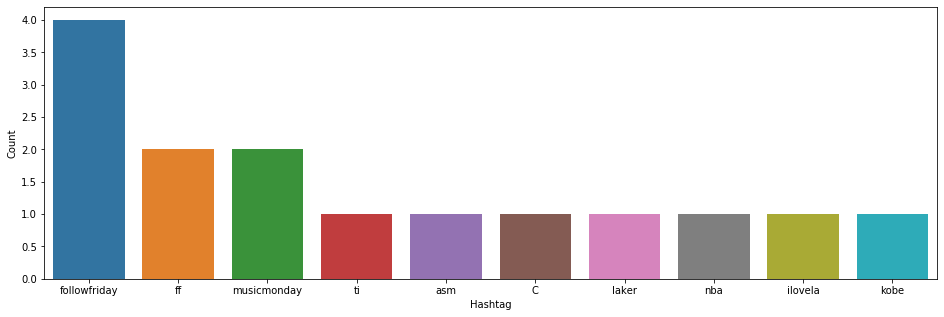

In [18]:
a = nltk.FreqDist(HT_negative)
d = pd.DataFrame({
    "Hashtag": list(a.keys()),
    "count": list(a.values())
})
d = d.nlargest(columns="count", n=10)

plt.figure(figsize=(16, 5))
ax = sns.barplot(data=d, x="Hashtag", y="count")
ax.set(ylabel="Count")
plt.show()

## Feature Selection and Engineering

### Count Vectorizer

In [19]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(stop_words="english")
bow = bow_vectorizer.fit_transform(data["tidy_tweet"])

X_count_feat = pd.concat([data["body_len"], data["punct%"], pd.DataFrame(bow.toarray())], axis=1)
X_count_feat.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,66,4.5,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,81,27.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,96,1.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,44,18.2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Tfidf Vectorizer

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(stop_words="english")
tfidf = tfidf_vectorizer.fit_transform(data["tidy_tweet"])

X_tfidf_feat = pd.concat([data["body_len"], data["punct%"], pd.DataFrame(tfidf.toarray())], axis=1)
X_tfidf_feat.head()

,body_len,punct%,0,1,2,3,4,5,6,7,...,3934,3935,3936,3937,3938,3939,3940,3941,3942,3943
0,92,1.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,66,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,81,27.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,96,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,44,18.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Cross Validating classification algorithms

In [21]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

model = []
model.append(("LogisticRegression", LogisticRegression()))
model.append(("RandomForestClassifier", RandomForestClassifier()))
model.append(("GradientBoostingClassifier", GradientBoostingClassifier()))
model.append(("DecisionTreeClassifier", DecisionTreeClassifier()))
model.append(("GaussianNB", GaussianNB()))
model.append(("KNeighborsClassifier", KNeighborsClassifier()))
model.append(("SVC", SVC()))

X_count_feat = preprocessing.scale(X_count_feat)
X_tfidf_feat = preprocessing.scale(X_tfidf_feat)

### 10-fold cross validation with X_count_feat data

In [22]:
for mod, clf in model:
    scores = cross_val_score(clf, X_count_feat, data["label"], scoring="accuracy", cv=10)
    print("Model is %s and Score %f" % (mod, scores.mean()))

Model is LogisticRegression and Score 0.643500
Model is RandomForestClassifier and Score 0.665000
Model is GradientBoostingClassifier and Score 0.642500
Model is DecisionTreeClassifier and Score 0.587000
Model is GaussianNB and Score 0.562000
Model is KNeighborsClassifier and Score 0.604500
Model is SVC and Score 0.643000


### 10-fold cross validation with X_tfidf_feat data

In [23]:
for mod, clf in model:
    scores = cross_val_score(clf, X_tfidf_feat, data["label"], scoring="accuracy", cv=10)
    print("Model is %s and Score %f" % (mod, scores.mean()))

Model is LogisticRegression and Score 0.636500
Model is RandomForestClassifier and Score 0.664500
Model is GradientBoostingClassifier and Score 0.628000
Model is DecisionTreeClassifier and Score 0.583500
Model is GaussianNB and Score 0.553500
Model is KNeighborsClassifier and Score 0.542500
Model is SVC and Score 0.656000


### Parameter tuning Linear Regression Count Vectorizer

In [24]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=10)
grid.fit(X_count_feat, data["label"])

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [25]:
grid.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [26]:
Logistic_model = LogisticRegression(
    C=0.1,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    max_iter=100,
    multi_class="auto",
    n_jobs=None,
    penalty="l2",
    random_state=None,
    solver="lbfgs",
    tol=0.0001,
    verbose=0,
    warm_start=False
)

scores = cross_val_score(Logistic_model, X_count_feat, data["label"], scoring="accuracy", cv=10)
print("Model is %s and Score %f" % ("LogisticRegression", scores.mean()))

Model is LogisticRegression and Score 0.650500


### Parameter tuning Linear Regression TfiDf Vectorizer

In [27]:
param_grid = {"C": [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=10)
grid.fit(X_tfidf_feat, data["label"])

GridSearchCV(cv=10, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [28]:
grid.best_estimator_

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
Logistic_model = LogisticRegression(
    C=1,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    max_iter=100,
    multi_class="auto",
    n_jobs=None,
    penalty="l2",
    random_state=None,
    solver="lbfgs",
    tol=0.0001,
    verbose=0,
    warm_start=False
)

scores = cross_val_score(Logistic_model, X_tfidf_feat, data["label"], scoring="accuracy", cv=10)
print("Model is %s and Score %f" % ("LogisticRegression", scores.mean()))

Model is LogisticRegression and Score 0.636500


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X_count_feat, data["label"], test_size=0.33, random_state=42)

In [33]:
model = LogisticRegression(
    C=0.1,
    class_weight=None,
    dual=False,
    fit_intercept=True,
    intercept_scaling=1,
    l1_ratio=None,
    max_iter=100,
    multi_class="auto",
    n_jobs=None,
    penalty="l2",
    random_state=None,
    solver="lbfgs",
    tol=0.0001,
    verbose=0,
    warm_start=False
)

model.fit(X_train, y_train)

pred = model.predict(X_test)

metrics.accuracy_score(pred, y_test)

0.6590909090909091

In [34]:
metrics.confusion_matrix(y_test, pred)

array([[217,  96],
       [129, 218]])